In [1]:
import numpy as np
import pylibdl as libdl
import time
import torch, torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(0)

In [2]:
# hyperparameter
lr = 0.001
lr_decay = .99
filter_sizes = [5, 5]
hidden_units = [16, 32, 64]
batch_size = 64
log_every = 10

In [3]:
# dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
train_data = MNIST('dataset/', train=True, download=True, transform=transform)
test_data = MNIST('dataset/', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [4]:
# weights and biases for the convolutional neural network
F1 = libdl.tensor(np.random.normal(0, 1 / np.sqrt(filter_sizes[0] * filter_sizes[0]), (1, filter_sizes[0], filter_sizes[0], hidden_units[0])), True)
B1 = libdl.tensor(np.zeros(hidden_units[0]), True)
F2 = libdl.tensor(np.random.normal(0, 1 / np.sqrt(hidden_units[0] * filter_sizes[1] * filter_sizes[1]), (hidden_units[0], filter_sizes[1], filter_sizes[1], hidden_units[1])), True)
B2 = libdl.tensor(np.zeros(hidden_units[1]), True)

W3 = libdl.tensor(np.random.normal(0, 1 / np.sqrt(49 * hidden_units[1]), (hidden_units[2], 49 * hidden_units[1])), True)
B3 = libdl.tensor(np.zeros(hidden_units[2]), True)
W4 = libdl.tensor(np.random.normal(0, 1 / np.sqrt(hidden_units[2]), (10, hidden_units[2])), True)
B4 = libdl.tensor(np.zeros(10), True)
parameters = [F1, B1, F2, B2, W3, B3, W4, B4]

In [5]:
# forward pass
def forward(x):
    h1 = libdl.leaky_relu(libdl.maxpool_2d(libdl.conv_2d(x, F1, B1), 2))
    h2 = libdl.leaky_relu(libdl.maxpool_2d(libdl.conv_2d(h1, F2, B2), 2))
    h2 = libdl.reshape(h2, (49 * hidden_units[1], -1))
    h3 = libdl.leaky_relu(libdl.matmul(W3, h2) + B3)
    return libdl.matmul(W4, h3) + B4

In [6]:
# training
optim = libdl.optim.Adam(parameters, lr)
print("Iteration | Loss")
start_time = time.time()
for i, (x, y) in enumerate(train_loader):
    x = libdl.tensor(x.numpy().transpose((1, 2, 3, 0)))
    y = libdl.tensor(np.eye(10)[y.numpy()].transpose())  # onehot encoding

    yp = forward(x)
    loss = libdl.cross_entropy_with_logits(yp, y)
    loss.backward()
    
    optim.step()
    optim.zero_grad()    
    optim.lr *= lr_decay

    if i % log_every == 0:
        print(f"{i:9d} | {loss.numpy():.4f}")

    if i >= 50: # Only train for 50 iterations. That's enough to show that my library works
        break

print(f'Trainig took: {time.time() - start_time:.2f}s')

Iteration | Loss
        0 | 2.4340
       10 | 2.3552
       20 | 2.2955
       30 | 2.2377
       40 | 2.1676
       50 | 2.1170
Trainig took: 3.67s


In [12]:
# test accuracy
accs = []
for i, (x, y) in enumerate(test_loader):
    x = libdl.tensor(x.numpy().transpose((1, 2, 3, 0)))
    y = y.numpy()

    yp = forward(x).numpy().argmax(axis=0)
    accs.append(np.mean(yp == y))
    if i >= 10:
        break

print(f"Test accuracy: {np.mean(accs)*100:.2f}%")

Test accuracy: 90.34%


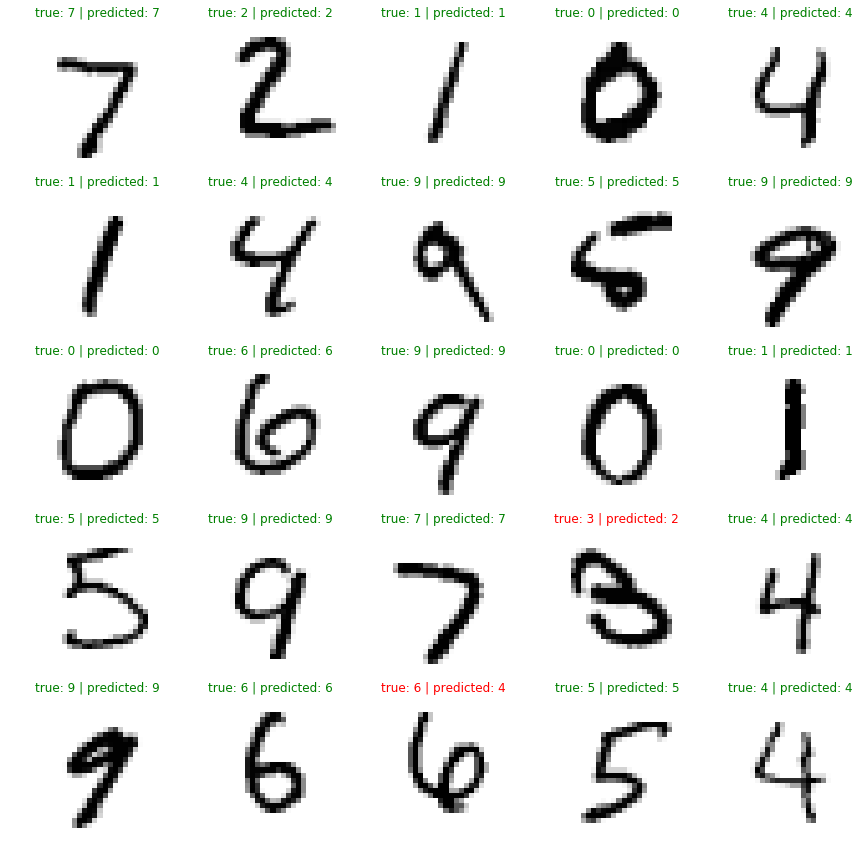

In [8]:
# visualization
grid_size = 5
t = libdl.tensor(np.concatenate([test_data[i][0][None] for i in range(grid_size * grid_size)]).transpose((1, 2, 3, 0)))
lp = forward(t).numpy().argmax(axis=0)
gs = gridspec.GridSpec(grid_size, grid_size)
plt.figure(figsize=(15,15)) 
for i in range(grid_size*grid_size):
    plt.subplot(gs[i])
    plt.axis('off')
    plt.title(f'true: {test_data[i][1]} | predicted: {lp[i]}', color='g' if test_data[i][1] == lp[i] else 'r')
    plt.imshow(1-test_data[i][0].numpy().squeeze(), cmap='gray')